# Feature Evaluation

**Objective:**
Analyze **RMS**, **VAR**, and **WL** features to determine the optimal window size for maximizing Accuracy while minimizing Detection Delay.

## 1. Setup

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
from src import visualization, data_loader, filters, features, config
visualization.set_plot_style()

Style set. LaTeX: False


## 2. Load and Preprocess
Loading labeled data and filtering it with the optimal filter (6th Order Butterworth).

In [2]:
DATA_FILE = "../data/labeled_data.csv"

df = data_loader.load_labeled_csv(DATA_FILE)
# Convert using config
raw_signal = (df['RawValue'] / ((2**config.ADC_BITS)-1) * config.V_REF).values
raw_signal = raw_signal - np.mean(raw_signal)
labels = df['LabelNumeric'].values

clean_signal = filters.apply_butterworth_sos(raw_signal, order=6, fs=config.FS)

## 3. Window Size Optimization
Calculating Accuracy and Detection Delay for window sizes 30ms - 200ms.

In [7]:
window_sizes = range(30, 201, 10)
results = {'RMS': [], 'VAR': [], 'WL': []}
delays = {'RMS': [], 'VAR': [], 'WL': []}

feature_funcs = {'RMS': features.calculate_rms, 'VAR': features.calculate_var, 'WL': features.calculate_wl}

def calculate_metrics(y_true, y_pred, fs):
    """Calculates Accuracy and average Detection Delay (in ms)."""
    # 1. Accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # 2. Detection Delay
    # Find indices where label goes 0 -> 1 (Onset)
    onsets = np.where(np.diff(y_true, prepend=0) == 1)[0]
    
    delay_values = []
    for onset in onsets:
        # Look for the first detection (1) in the prediction signal *after* the onset
        # We search up to 500ms after onset to find the trigger
        search_limit = min(onset + 500, len(y_pred))
        window_pred = y_pred[onset:search_limit]
        
        # Find first index where prediction is 1
        hits = np.where(window_pred == 1)[0]
        
        if len(hits) > 0:
            # Time difference in ms
            delay_ms = (hits[0] / fs) * 1000
            delay_values.append(delay_ms)
            
    avg_delay = np.mean(delay_values) if delay_values else 0
    return acc, avg_delay

print("Starting evaluation loop...")

for win in window_sizes:
    samples = int(win * config.FS / 1000)
    
    # Align: The feature at index i is based on signal[i-win:i]
    # We compare it to the label at index i.
    target_labels = labels[samples-1:] 
    
    for name, func in feature_funcs.items():
        # Compute feature over the whole signal
        feats = func(clean_signal, samples)
        
        # --- Threshold Grid Search ---
        # We want the threshold that gives the best accuracy
        # Heuristic: Scan between 5th and 95th percentile of feature values
        min_v = np.percentile(feats, 5)
        max_v = np.percentile(feats, 95)
        
        best_acc = 0
        best_delay = 0
        best_thresh = 0
        
        # Test 50 candidate thresholds
        candidates = np.linspace(min_v, max_v, 50)
        
        for thresh in candidates:
            preds = (feats > thresh).astype(int)
            
            # Fast accuracy check first
            acc = accuracy_score(target_labels, preds)
            
            if acc > best_acc:
                best_acc = acc
                best_thresh = thresh
                # Only calculate costly delay metric for the best threshold candidate
                _, best_delay = calculate_metrics(target_labels, preds, config.FS)
        
        results[name].append(best_acc * 100)
        delays[name].append(best_delay)

print("Evaluation complete.")

Starting evaluation loop...
Evaluation complete.


## 4. Results Plotting
Visualizing the trade-off between Accuracy and Delay.

Saved [DRAFT]: ../results/drafts/feature_accuracy_delay.png


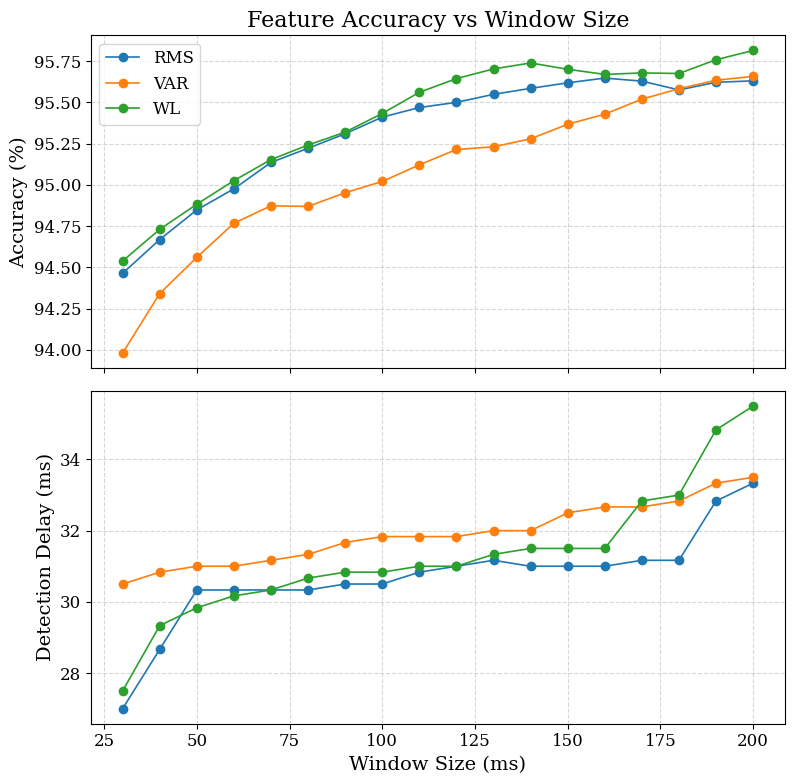

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

for name in ['RMS', 'VAR', 'WL']:
    color = visualization.COLORS.get(name, 'black')
    
    ax1.plot(window_sizes, results[name], marker='o', label=name, color=color)
    ax2.plot(window_sizes, delays[name], marker='o', label=name, color=color)

ax1.set_ylabel("Accuracy (%)")
ax1.legend()
ax1.set_title("Feature Accuracy vs Window Size")

ax2.set_ylabel("Detection Delay (ms)")
ax2.set_xlabel("Window Size (ms)")
ax2.grid(True)

visualization.save_fig(fig, 'feature_accuracy_delay.png')
plt.show()